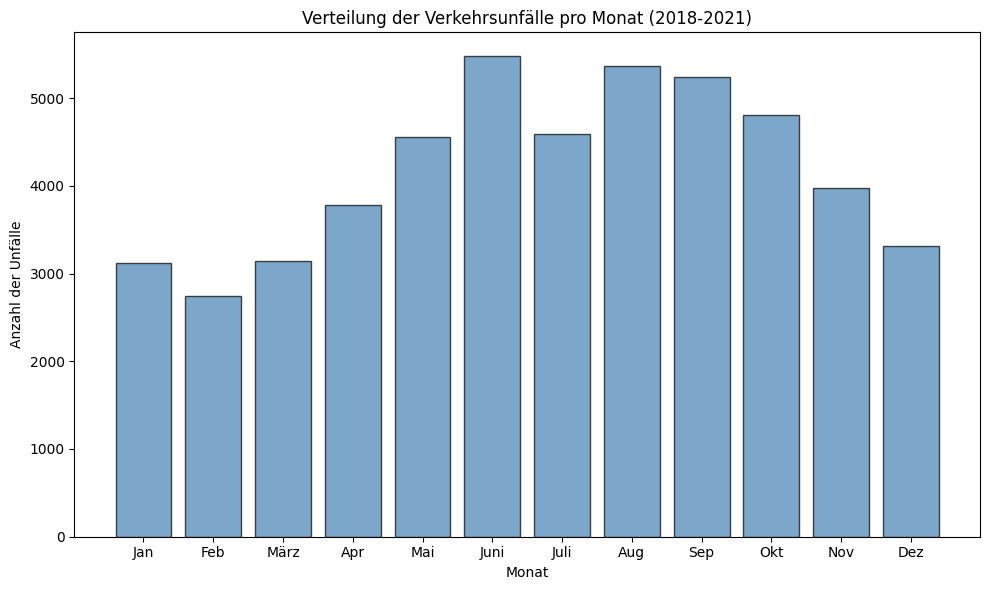

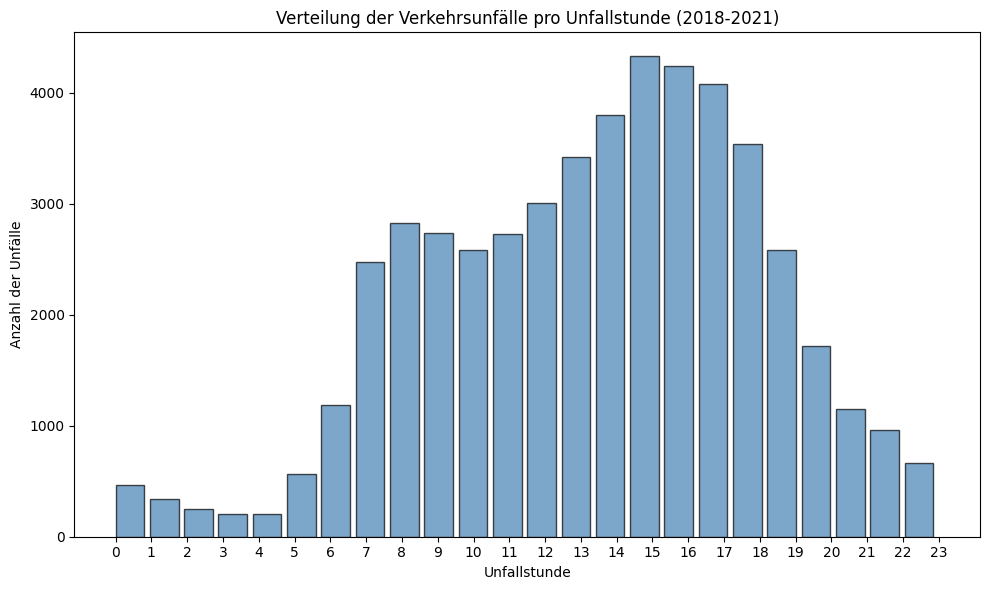

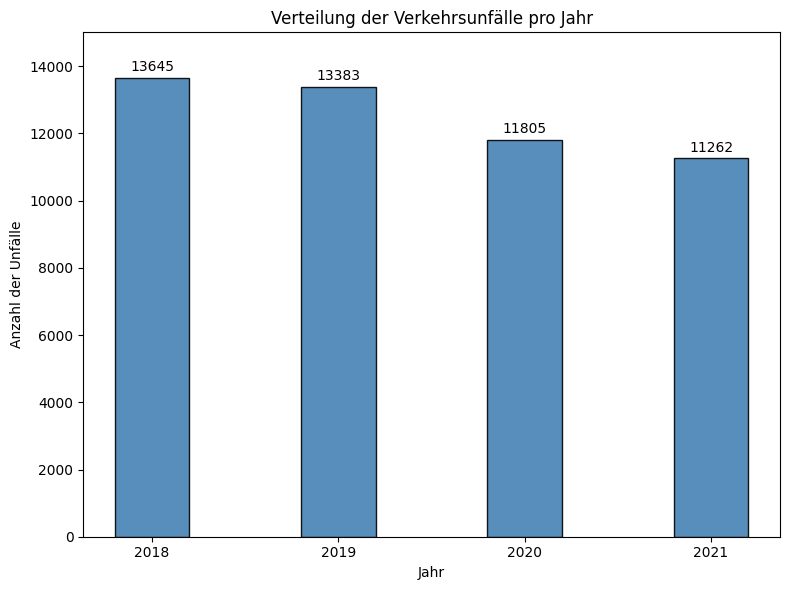

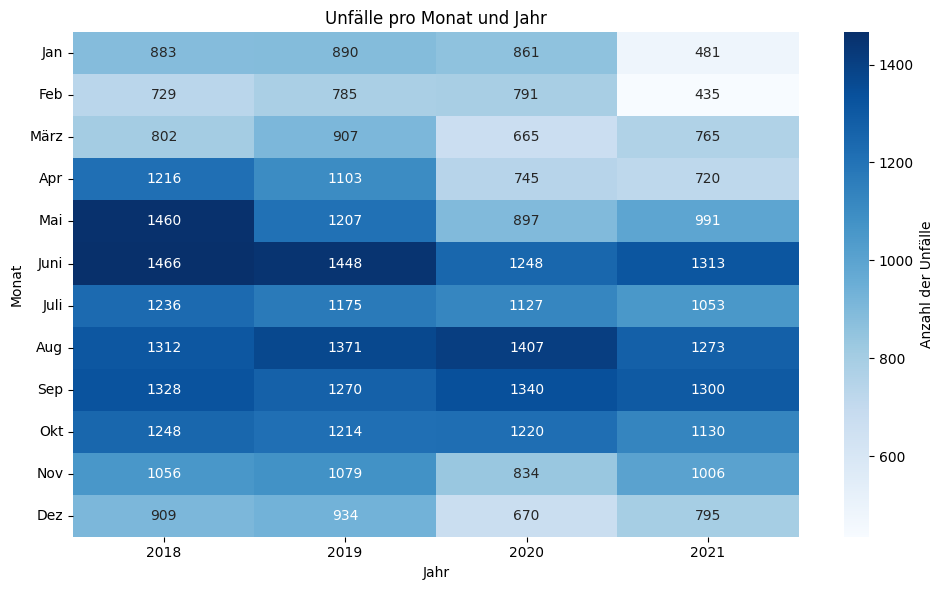

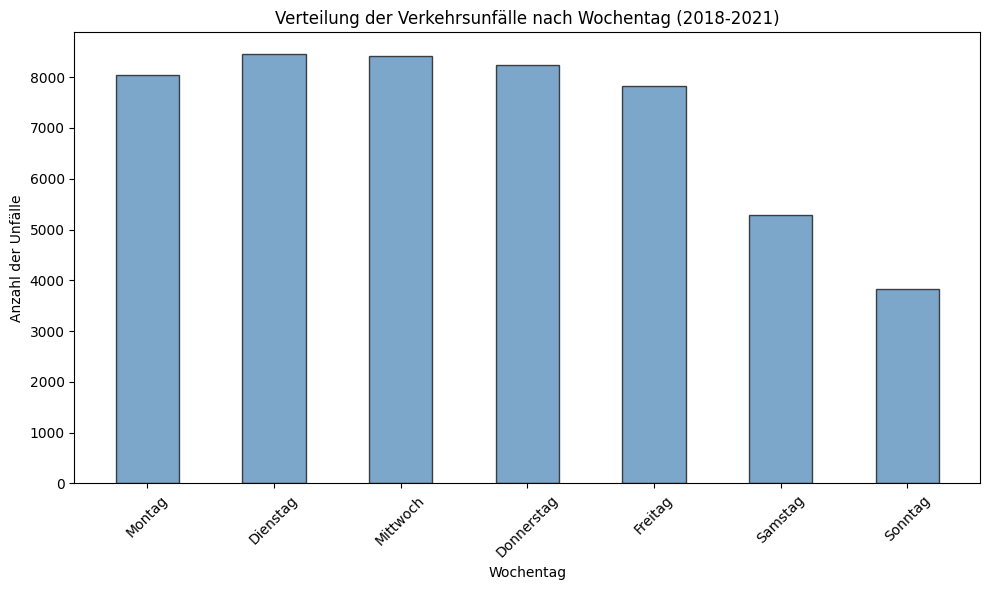

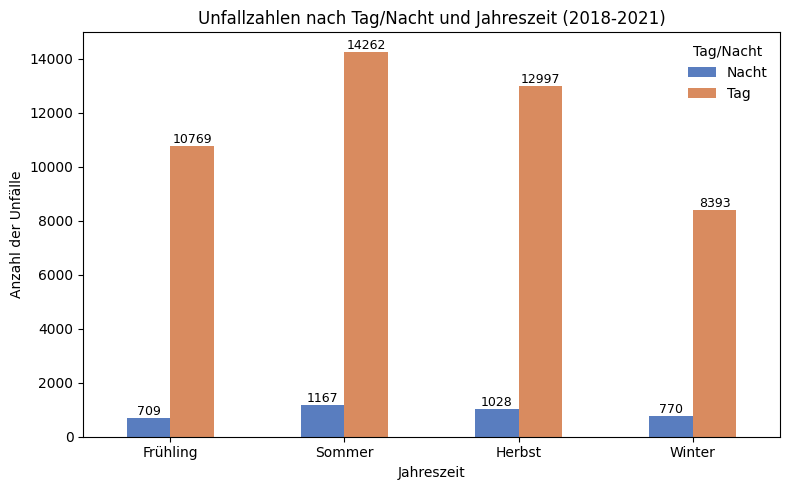

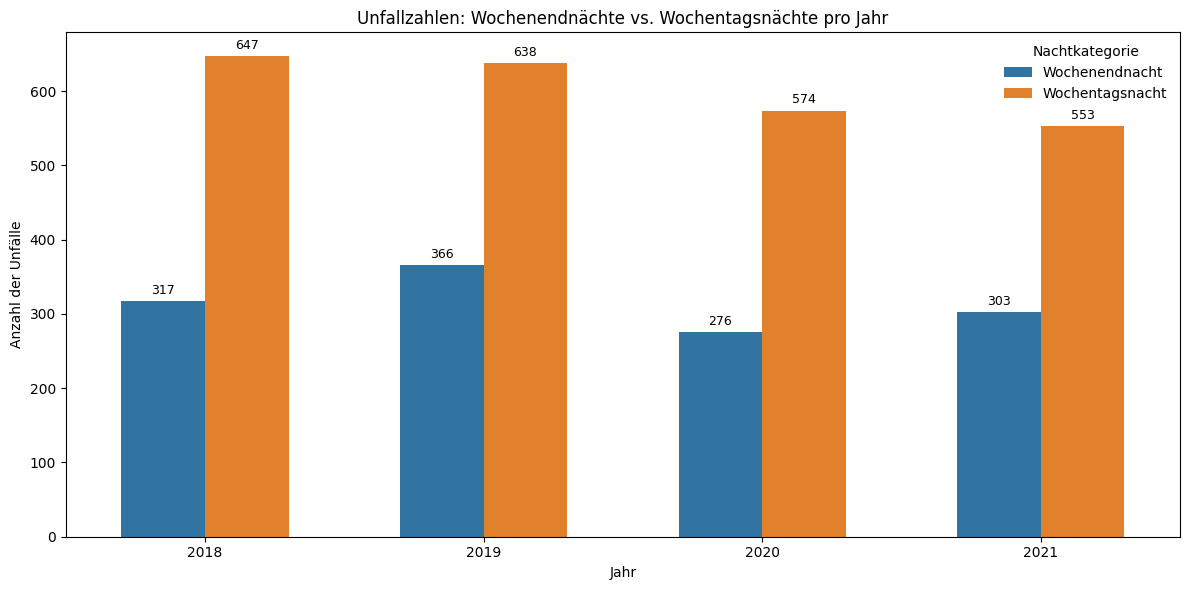

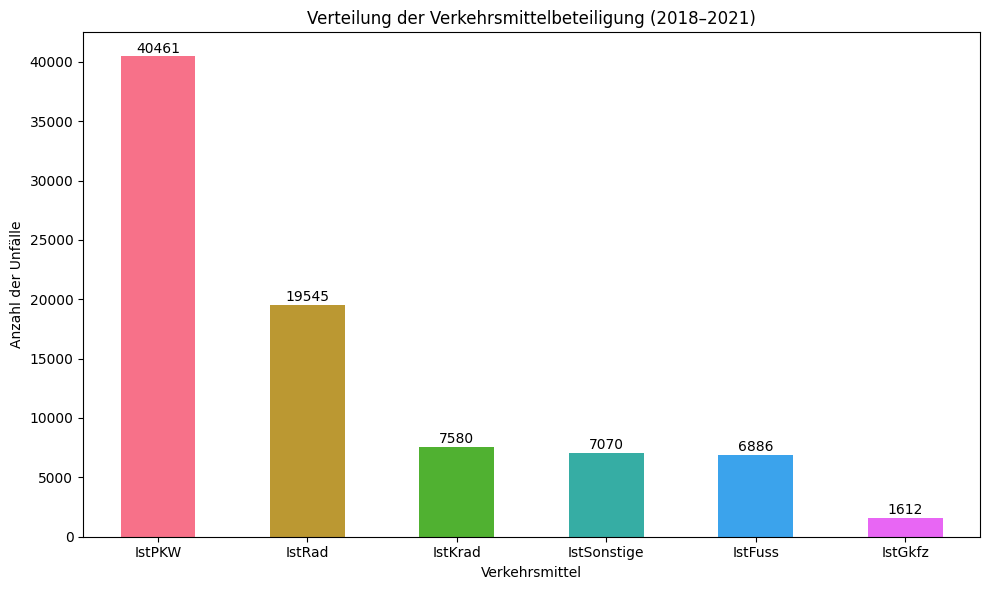

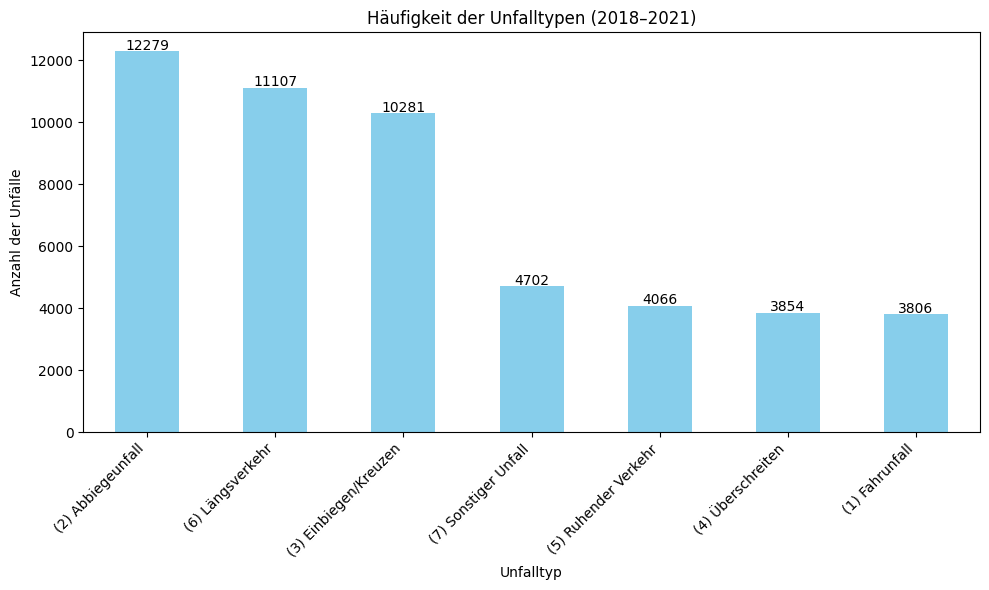

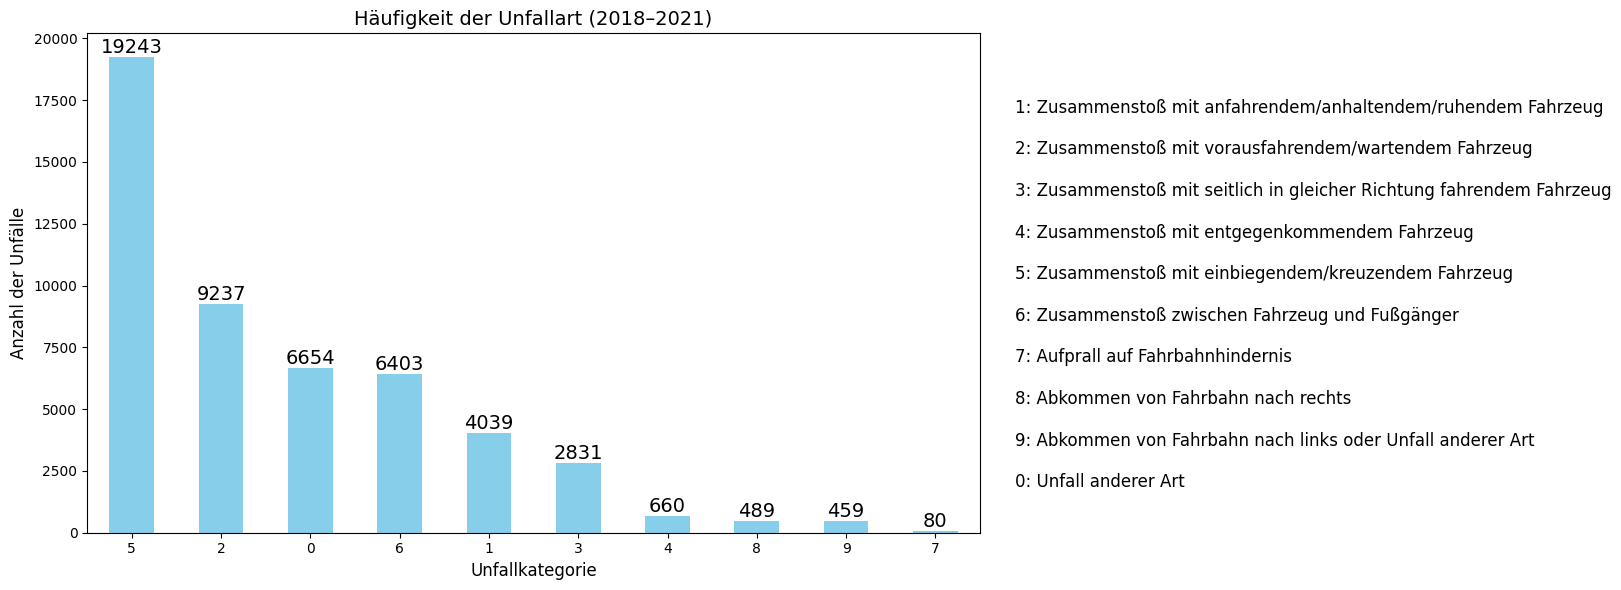

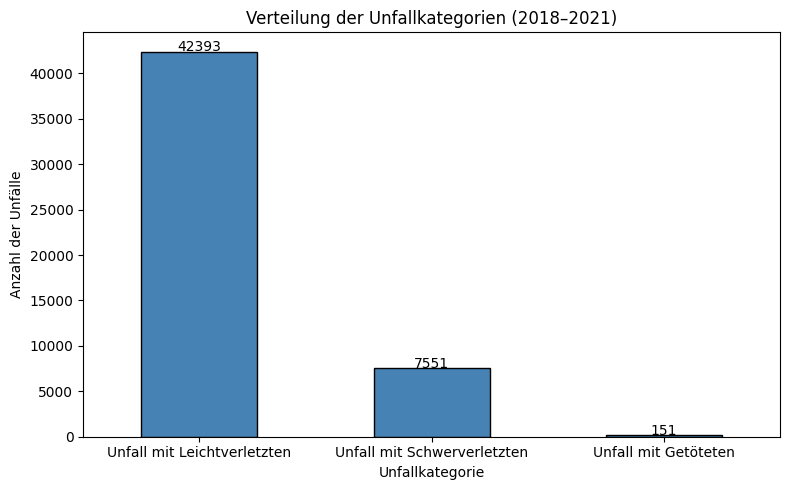

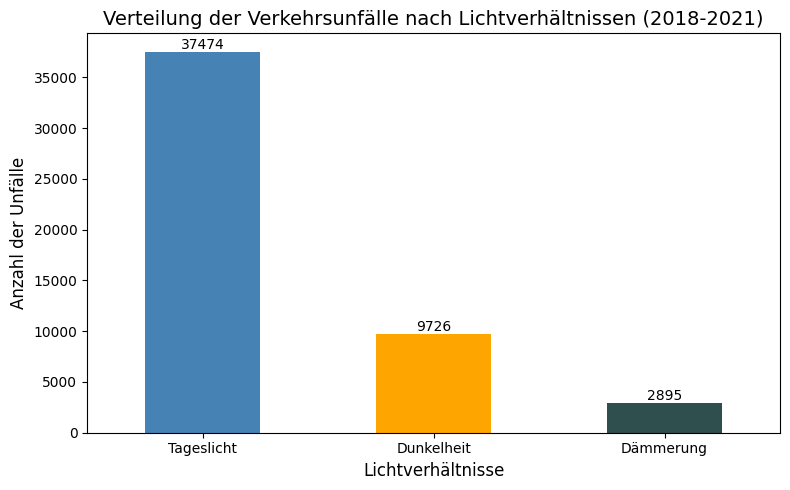

Korrelationsmatrix für numerische Variablen:
               UJAHR    UMONAT   USTUNDE  UWOCHENTAG
UJAHR       1.000000  0.044308  0.010940   -0.000338
UMONAT      0.044308  1.000000 -0.002088    0.012250
USTUNDE     0.010940 -0.002088  1.000000    0.015816
UWOCHENTAG -0.000338  0.012250  0.015816    1.000000
Stärkste Assoziationen zwischen kategorialen Variablen:
BEZ und LOR_ab_2021: Cramer's V = 0.995
UART und IstFuss: Cramer's V = 0.957
UTYP1 und IstFuss: Cramer's V = 0.758
UTYP1 und UART: Cramer's V = 0.625
UART und IstPKW: Cramer's V = 0.428
UTYP1 und IstPKW: Cramer's V = 0.391
UART und IstRad: Cramer's V = 0.368
IstPKW und IstSonstige: Cramer's V = 0.300
IstRad und IstKrad: Cramer's V = 0.295
UTYP1 und IstRad: Cramer's V = 0.291


In [18]:
# ----------------------------------------------
# Verkehrsunfallanalyse Berlin (2018–2021)
# Visualisierung & Aggregation bereinigter Daten
# ----------------------------------------------

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

# Ordner für Ausgabeplots anlegen
os.makedirs("output/plots", exist_ok=True)

# ------------------------------
# 1. Datensatz laden
# ------------------------------
filtered_data2 = pd.read_csv("bereinigte_daten.csv")

# ------------------------------
# 2. Neue Variablen erstellen
# ------------------------------

def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Frühling'
    elif month in [6, 7, 8]: return 'Sommer'
    else: return 'Herbst'

filtered_data2['Jahreszeit'] = filtered_data2['UMONAT'].apply(get_season)

wochentage_map = {1: 'Sonntag', 2: 'Montag', 3: 'Dienstag', 4: 'Mittwoch', 5: 'Donnerstag', 6: 'Freitag', 7: 'Samstag'}
filtered_data2['Wochentag'] = filtered_data2['UWOCHENTAG'].map(wochentage_map)

ukategorie_map = {1: 'Unfall mit Getöteten', 2: 'Unfall mit Schwerverletzten', 3: 'Unfall mit Leichtverletzten'}
filtered_data2['Kategorie'] = filtered_data2['UKATEGORIE'].map(ukategorie_map)

filtered_data2['Wochenende'] = filtered_data2['Wochentag'].isin(['Samstag', 'Sonntag']).astype(int)

# Tag/Nacht-Kategorisierung (individuelle Annahme)
filtered_data2['Tag/Nacht'] = filtered_data2['USTUNDE'].apply(lambda x: 'Tag' if 6 <= x < 22 else 'Nacht')

# Nachtkategorien
filtered_data2['Nachtkategorie'] = filtered_data2.apply(
    lambda row: 'Wochenendnacht' if row['Tag/Nacht'] == 'Nacht' and row['Wochenende'] == 1 else
                ('Wochentagsnacht' if row['Tag/Nacht'] == 'Nacht' and row['Wochenende'] == 0 else None), axis=1)

nachtunfaelle = filtered_data2[filtered_data2['Nachtkategorie'].notnull()]

# ------------------------------
# 3. Aggregationen vorbereiten
# ------------------------------

yearly_accidents = filtered_data2.groupby('UJAHR').size()
monthly_accidents = filtered_data2.groupby('UMONAT').size()
daily_accidents = filtered_data2.groupby('UWOCHENTAG').size()
hourly_accidents = filtered_data2.groupby('USTUNDE').size()

year_month_accidents = filtered_data2.groupby(['UJAHR', 'UMONAT']).size().reset_index(name='Anzahl_Unfaelle')
weekday_year_accidents = filtered_data2.groupby(['UJAHR', 'UWOCHENTAG']).size().reset_index(name='Anzahl_Unfaelle')
month_hour_accidents = filtered_data2.groupby(['UMONAT', 'USTUNDE']).size().reset_index(name='Anzahl_Unfaelle')
weekday_hour_accidents = filtered_data2.groupby(['UWOCHENTAG', 'USTUNDE']).size().reset_index(name='Anzahl_Unfaelle')
month_hour_year_accidents = filtered_data2.groupby(['UJAHR', 'UMONAT', 'USTUNDE']).size().reset_index(name='Anzahl_Unfaelle')
hour_weekday_year_accidents = filtered_data2.groupby(['UJAHR', 'UWOCHENTAG', 'USTUNDE']).size().reset_index(name='Anzahl_Unfaelle')

seasonal_accidents = filtered_data2.groupby(['Jahreszeit']).size().reset_index(name='Anzahl_Unfaelle')
day_night_season = filtered_data2.groupby(['Jahreszeit', 'Tag/Nacht']).size().reset_index(name='Anzahl_Unfaelle')
night_year = filtered_data2.groupby(['UJAHR', 'Nachtkategorie']).size().reset_index(name='Anzahl_Unfaelle')
night_season = nachtunfaelle.groupby(['Jahreszeit', 'Nachtkategorie']).size().reset_index(name='Anzahl_Unfaelle')

# ------------------------------
# 4. Beispielhafte Visualisierung: Unfälle pro Monat
# ------------------------------
month_abbr = ['Jan', 'Feb', 'März', 'Apr', 'Mai', 'Juni', 'Juli', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez']
plt.figure(figsize=(10, 6))
plt.bar(monthly_accidents.index, monthly_accidents.values, color='#4682b4', edgecolor='k', alpha=0.7)
plt.title("Verteilung der Verkehrsunfälle pro Monat (2018-2021)")
plt.xlabel("Monat")
plt.ylabel("Anzahl der Unfälle")
plt.xticks(ticks=range(1, 13), labels=month_abbr)
plt.grid(False)
plt.tight_layout()
plt.savefig("output/plots/Unfaelle_pro_Monat.png", dpi=100)
plt.show()

# ------------------------------
# 5. Visualisierung: Unfälle pro Stunde
# ------------------------------
plt.figure(figsize=(10, 6))
plt.hist(filtered_data2['USTUNDE'].dropna(), bins=24, edgecolor='k', color='#4682b4', alpha=0.7, width=0.8)
plt.title('Verteilung der Verkehrsunfälle pro Unfallstunde (2018-2021)')
plt.xlabel('Unfallstunde')
plt.xticks(range(0, 24))
plt.ylabel('Anzahl der Unfälle')
plt.grid(False)
plt.tight_layout()
plt.savefig("output/plots/Unfaelle_pro_Stunde.png", dpi=100)
plt.show()

# ------------------------------
# 6. Visualisierung: Unfälle nach Jahr
# ------------------------------
plt.figure(figsize=(8, 6))
bars = plt.bar(yearly_accidents.index, yearly_accidents.values, color='#4682b4', edgecolor='k', alpha=0.9, width=0.4)
plt.ylim(0, max(yearly_accidents.values) * 1.1)
plt.title('Verteilung der Verkehrsunfälle pro Jahr')
plt.xlabel('Jahr')
plt.ylabel('Anzahl der Unfälle')
plt.xticks(yearly_accidents.index)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200, f'{int(bar.get_height())}', ha='center')
plt.grid(False)
plt.tight_layout()
plt.savefig("output/plots/Unfaelle_pro_Jahr.png", dpi=100)
plt.show()

# ------------------------------
# 7. Visualisierung: Heatmap Jahr-Monat
# ------------------------------
year_month_pivot = year_month_accidents.pivot(index='UMONAT', columns='UJAHR', values='Anzahl_Unfaelle')
plt.figure(figsize=(10, 6))
sns.heatmap(year_month_pivot, annot=True, fmt='.0f', cmap='Blues', cbar_kws={'label': 'Anzahl der Unfälle'})
plt.yticks(ticks=np.arange(12) + 0.5, labels=month_abbr, rotation=0)
plt.title('Unfälle pro Monat und Jahr')
plt.xlabel('Jahr')
plt.ylabel('Monat')
plt.tight_layout()
plt.savefig("output/plots/Unfaelle_Monat_Jahr_Heatmap.png", dpi=100)
plt.show()

# ------------------------------
# 8. Visualisierung: Unfälle nach Wochentag
# ------------------------------
wochentage_reihenfolge = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']
wochentag_counts = [filtered_data2['Wochentag'].value_counts().get(wt, 0) for wt in wochentage_reihenfolge]
plt.figure(figsize=(10, 6))
plt.bar(wochentage_reihenfolge, wochentag_counts, edgecolor='k', color='#4682b4', alpha=0.7, width=0.5)
plt.title('Verteilung der Verkehrsunfälle nach Wochentag (2018-2021)')
plt.xlabel('Wochentag')
plt.ylabel('Anzahl der Unfälle')
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.savefig("output/plots/Unfaelle_nach_Wochentag.png", dpi=100)
plt.show()

# ------------------------------
# 9. Visualisierung: Unfallzahlen nach Tag/Nacht und Jahreszeit
# ------------------------------
jahreszeiten_order = ['Frühling', 'Sommer', 'Herbst', 'Winter']
day_night_season['Jahreszeit'] = pd.Categorical(day_night_season['Jahreszeit'], categories=jahreszeiten_order, ordered=True)
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Jahreszeit', y='Anzahl_Unfaelle', hue='Tag/Nacht', data=day_night_season, palette='muted', width=0.5)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9)
plt.title("Unfallzahlen nach Tag/Nacht und Jahreszeit (2018-2021)")
plt.xlabel("Jahreszeit")
plt.ylabel("Anzahl der Unfälle")
plt.legend(title="Tag/Nacht", loc='upper right', frameon=False)
plt.grid(False)
plt.tight_layout()
plt.savefig("output/plots/Unfaelle_Tag_Nacht_Jahreszeit.png", dpi=100)
plt.show()

# ------------------------------
# 10. Visualisierung: Unfallzahlen nach Nachtkategorie und Jahr
# ------------------------------
night_year['UJAHR'] = night_year['UJAHR'].astype(str)
plt.figure(figsize=(12, 6))
bars = sns.barplot(x='UJAHR', y='Anzahl_Unfaelle', hue='Nachtkategorie', data=night_year, width=0.6)
for container in bars.containers:
    bars.bar_label(container, fmt='%d', label_type='edge', fontsize=9, padding=3)
plt.title("Unfallzahlen: Wochenendnächte vs. Wochentagsnächte pro Jahr")
plt.xlabel("Jahr")
plt.ylabel("Anzahl der Unfälle")
plt.legend(title="Nachtkategorie", loc='upper right', frameon=False)
plt.grid(False)
plt.tight_layout()
plt.savefig("output/plots/Nachtkategorie_nach_Jahr.png", dpi=100)
plt.show()

# ------------------------------
# 11. Visualisierung: Verkehrsmittelbeteiligung (gesamt)
# ------------------------------
vehicles = ['IstRad', 'IstPKW', 'IstFuss', 'IstKrad', 'IstGkfz', 'IstSonstige']
vehicle_counts = filtered_data2[vehicles].sum().sort_values(ascending=False)
colors = sns.color_palette('husl', len(vehicle_counts))
plt.figure(figsize=(10, 6))
bars = vehicle_counts.plot(kind='bar', color=colors)
plt.title('Verteilung der Verkehrsmittelbeteiligung (2018–2021)')
plt.xlabel('Verkehrsmittel')
plt.ylabel('Anzahl der Unfälle')
plt.xticks(rotation=0)
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, int(bar.get_height()), ha='center', va='bottom')
plt.grid(False)
plt.tight_layout()
plt.savefig("output/plots/Verkehrsmittelbeteiligung.png", dpi=100)
plt.show()

# ------------------------------
# 12. Visualisierung: Verteilung der Unfalltypen (UTYP1)
# ------------------------------
utyp_labels = {
    1: '(1) Fahrunfall',
    2: '(2) Abbiegeunfall',
    3: '(3) Einbiegen/Kreuzen',
    4: '(4) Überschreiten',
    5: '(5) Ruhender Verkehr',
    6: '(6) Längsverkehr',
    7: '(7) Sonstiger Unfall'
}
accident_types = filtered_data2['UTYP1'].value_counts().rename(index=utyp_labels)
plt.figure(figsize=(10, 6))
bars = accident_types.plot(kind='bar', color='#87CEEB')
plt.title('Häufigkeit der Unfalltypen (2018–2021)')
plt.xlabel('Unfalltyp')
plt.ylabel('Anzahl der Unfälle')
plt.xticks(rotation=45, ha='right')
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, int(bar.get_height()), ha='center')
plt.grid(False)
plt.tight_layout()
plt.savefig("output/plots/Unfalltypen_UTYP1.png", dpi=100)
plt.show()

# ------------------------------
# 13. Visualisierung: Verteilung der Unfallarten (UART)
# ------------------------------
accident_types = filtered_data2['UART'].value_counts()
legend_texts = [
    "1: Zusammenstoß mit anfahrendem/anhaltendem/ruhendem Fahrzeug",
    "2: Zusammenstoß mit vorausfahrendem/wartendem Fahrzeug",
    "3: Zusammenstoß mit seitlich in gleicher Richtung fahrendem Fahrzeug",
    "4: Zusammenstoß mit entgegenkommendem Fahrzeug",
    "5: Zusammenstoß mit einbiegendem/kreuzendem Fahrzeug",
    "6: Zusammenstoß zwischen Fahrzeug und Fußgänger",
    "7: Aufprall auf Fahrbahnhindernis",
    "8: Abkommen von Fahrbahn nach rechts",
    "9: Abkommen von Fahrbahn nach links oder Unfall anderer Art",
    "0: Unfall anderer Art"
]

# Balkendiagramm
plt.figure(figsize=(10, 6))
bars = accident_types.plot(kind='bar', color='#87CEEB')

# Titel und Achsenbeschriftungen
plt.title('Häufigkeit der Unfallart (2018–2021)', fontsize=14)
plt.xlabel('Unfallkategorie', fontsize=12)
plt.ylabel('Anzahl der Unfälle', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)

# Zahlen auf den Balken anzeigen
for bar in bars.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 5,
        int(bar.get_height()),
        ha='center', va='bottom', fontsize=14, color='black'
    )

plt.grid(False)
plt.tight_layout()

# Legende mit größerem Zeilenabstand
plt.figtext(1.02, 0.5, "\n\n".join(legend_texts), fontsize=12, va='center')

# Speichern
plt.savefig("output/plots/Unfallarten_UART.png", dpi=100, bbox_inches='tight')
plt.show()

# ------------------------------
# 14. Visualisierung: Verteilung der Unfallkategorien (UKATEGORIE)
# ------------------------------
category_mapping = {
    1: 'Unfall mit Getöteten',
    2: 'Unfall mit Schwerverletzten',
    3: 'Unfall mit Leichtverletzten'
}

# Mapping anwenden
category_counts = filtered_data2['UKATEGORIE'].map(category_mapping).value_counts()

plt.figure(figsize=(8, 5))
bars = category_counts.plot(kind='bar', color='#4682b4', edgecolor='k')
plt.title('Verteilung der Unfallkategorien (2018–2021)')
plt.xlabel('Unfallkategorie')
plt.ylabel('Anzahl der Unfälle')
plt.xticks(rotation=0, ha='center')

# Balkenbeschriftung
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, int(bar.get_height()), ha='center')

plt.grid(False)
plt.tight_layout()
plt.savefig("output/plots/Unfallkategorien_UKATEGORIE.png", dpi=100)
plt.show()

# -------------------------------------------------
# Zuordnung der Bezirksnamen zu den numerischen IDs
bezirke_mapping = {
    1: 'Mitte', 2: 'Friedrichshain-Kreuzberg', 3: 'Pankow', 
    4: 'Charlottenburg-Wilmersdorf', 5: 'Spandau', 
    6: 'Steglitz-Zehlendorf', 7: 'Tempelhof-Schöneberg', 
    8: 'Neukölln', 9: 'Treptow-Köpenick', 
    10: 'Marzahn-Hellersdorf', 11: 'Lichtenberg', 12: 'Reinickendorf'
}

# -----------------------------------------------------
# Wochentag in lesbare Kategorien umwandeln
wochentage = {2: 'Montag', 3: 'Dienstag', 4: 'Mittwoch', 5: 'Donnerstag', 6: 'Freitag', 7: 'Samstag', 1: 'Sonntag'}
filtered_data2['Wochentag'] = filtered_data2['UWOCHENTAG'].map(wochentage)

# ------------------------------
# Unfälle nach Jahreszeit und Bezirk (Heatmap)
# ------------------------------
season_district_accidents = filtered_data2.groupby(['Jahreszeit', 'BEZ']).size().reset_index(name='Anzahl_Unfaelle')
heatmap_data = season_district_accidents.pivot(index='BEZ', columns='Jahreszeit', values='Anzahl_Unfaelle').fillna(0)
heatmap_data.index = [bezirke_mapping[bezirk] for bezirk in heatmap_data.index]

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='coolwarm', cbar_kws={'label': 'Unfälle'}, linewidths=0.5)
plt.title('Unfälle nach Jahreszeit und Bezirk (2018-2021)')
plt.xlabel('Jahreszeit')
plt.ylabel('Bezirk')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("output/plots/Unfaelle_Jahreszeit_Bezirk.png", dpi=100)
plt.close()

# ------------------------------
# Unfälle nach Bezirk und Jahr (Balkendiagramm)
# ------------------------------
month_district_accidents = filtered_data2.groupby(['UJAHR', 'BEZ']).size().reset_index(name='Anzahl_Unfaelle')
month_district_accidents['BEZ'] = month_district_accidents['BEZ'].map(bezirke_mapping)

plt.figure(figsize=(14, 8))
sns.barplot(x='BEZ', y='Anzahl_Unfaelle', hue='UJAHR', data=month_district_accidents, errorbar=None)
plt.xlabel("Bezirk")
plt.ylabel("Anzahl der Unfälle")
plt.title("Unfälle nach Bezirk und Jahr")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Jahr", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("output/plots/Unfaelle_nach_Bezirk_und_Jahr.png", dpi=100)
plt.close()

# ------------------------------
# Unfälle pro Bezirk nach Wochentag (Heatmap)
# ------------------------------
weekday_district = filtered_data2.groupby(['UWOCHENTAG', 'BEZ']).size().reset_index(name='Anzahl_Unfaelle')
weekday_district['UWOCHENTAG'] = weekday_district['UWOCHENTAG'].map(wochentage)
weekday_district['BEZ'] = weekday_district['BEZ'].map(bezirke_mapping)

bezirk_order = list(bezirke_mapping.values())
wochentag_order = ['Sonntag', 'Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag']

heatmap_data = weekday_district.pivot(index='BEZ', columns='UWOCHENTAG', values='Anzahl_Unfaelle').fillna(0)
heatmap_data = heatmap_data.reindex(bezirk_order, axis=0)
heatmap_data = heatmap_data[wochentag_order]

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Unfälle'})
plt.title("Unfälle pro Bezirk nach Wochentag (2018-2021)")
plt.xlabel("Wochentag")
plt.ylabel("Bezirk")
plt.tight_layout()
plt.savefig("output/plots/Unfaelle_Bezirk_Wochentag.png", dpi=100)
plt.close()

# ------------------------------
# Unfälle pro Bezirk nach Unfallstunde (Heatmap)
# ------------------------------
hour_district_accidents = filtered_data2.groupby(['USTUNDE', 'BEZ']).size().reset_index(name='Anzahl_Unfaelle')
hour_district_accidents['BEZ'] = hour_district_accidents['BEZ'].map(bezirke_mapping)

hour_order = list(range(24))

hour_district_pivot = hour_district_accidents.pivot(index='BEZ', columns='USTUNDE', values='Anzahl_Unfaelle').fillna(0)
hour_district_pivot = hour_district_pivot.reindex(bezirk_order, axis=0)
hour_district_pivot = hour_district_pivot[hour_order]

plt.figure(figsize=(14, 8))
sns.heatmap(hour_district_pivot, annot=True, fmt='.0f', cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Unfälle'})
plt.title("Unfälle pro Bezirk nach Unfallstunde (2018-2021)")
plt.xlabel("Unfallstunde")
plt.ylabel("Bezirk")
plt.tight_layout()
plt.savefig("output/plots/Unfaelle_Bezirk_Stunde.png", dpi=100)
plt.close()

############
# Mapping der Lichtverhältnisse
light_conditions_mapping = {
    0: 'Tageslicht',
    1: 'Dämmerung',
    2: 'Dunkelheit'
}

# Lichtverhältnisse in lesbare Form bringen
filtered_data2['ULICHTVERH'] = filtered_data2['ULICHTVERH'].map(light_conditions_mapping)

# Verteilung der Lichtverhältnisse zählen
light_conditions_counts = filtered_data2['ULICHTVERH'].value_counts()

# Balkendiagramm erstellen
plt.figure(figsize=(8, 5))
bars = light_conditions_counts.plot(kind='bar', color=['#4682b4', '#FFA500', '#2F4F4F'])  # Blau, Orange, Dunkelgrau

# Titel und Achsenbeschriftungen
plt.title('Verteilung der Verkehrsunfälle nach Lichtverhältnissen (2018-2021)', fontsize=14)
plt.xlabel('Lichtverhältnisse', fontsize=12)
plt.ylabel('Anzahl der Unfälle', fontsize=12)
plt.xticks(rotation=0, fontsize=10)  # Horizontal
plt.yticks(fontsize=10)

# Absolute Zahlen auf den Balken anzeigen
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, int(bar.get_height()), 
             ha='center', va='bottom', fontsize=10, color='black')

plt.grid(False)
plt.tight_layout()

# Grafik speichern
plt.savefig("output/plots/Verteilung_der_Unfälle_LichtV_(alle Jahre kombiniert).png", dpi=100)
plt.show()

########################### KORRELATION NUMERISCHER VARIABLEN ###########################

# Definiere die Liste numerischer Variablen zur Korrelationsanalyse
numerical_vars = ['UJAHR', 'UMONAT', 'USTUNDE', 'UWOCHENTAG']

# Berechne die Pearson-Korrelationsmatrix für die numerischen Variablen
corr_matrix = filtered_data2[numerical_vars].corr(method='pearson')

# Ausgabe der Korrelationsmatrix
print('Korrelationsmatrix für numerische Variablen:')
print(corr_matrix)

#########################################################################################


###################### CRAMÉR'S V FÜR KATEGORIALE VARIABLEN ############################

from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """Berechnet Cramér's V für zwei kategoriale Variablen."""
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Definiere relevante kategoriale Variablen zur Untersuchung der Zusammenhänge
categorical_vars = [
    'BEZ', 'LOR_ab_2021', 'UKATEGORIE', 'UTYP1', 'UART',
    'ULICHTVERH', 'USTRZUSTAND', 'IstRad', 'IstPKW',
    'IstFuss', 'IstKrad', 'IstGkfz', 'IstSonstige'
]

# Berechne paarweise Cramér's V nur für eindeutige Kombinationen (keine Duplikate)
cramers_results = {}
for i in range(len(categorical_vars)):
    for j in range(i + 1, len(categorical_vars)):
        var1, var2 = categorical_vars[i], categorical_vars[j]
        cramers_results[(var1, var2)] = cramers_v(filtered_data2[var1], filtered_data2[var2])

# Sortiere die Ergebnisse nach Stärke der Assoziation (absteigend)
sorted_cramers_results = sorted(cramers_results.items(), key=lambda x: x[1], reverse=True)

# Gib die Top 10 der stärksten Assoziationen aus
print("Stärkste Assoziationen zwischen kategorialen Variablen:")
for (var1, var2), value in sorted_cramers_results[:10]:
    print(f"{var1} und {var2}: Cramer's V = {value:.3f}")

#########################################################################################

